# Summary

**To get results**
- Simply run all cells to refresh.
- This notebook will use internet to download dataset and will write files to local disk.
- Assuming Anaconda python 3 with sklearn, tensorflow, keras, xgboost installed.
- I worked on this notebook on Saturday afternoon, Saturday evening and Sunday afternoon.

**Key learnings**
- Multiple methods are giving similar poor signal (AUC~0.6). Perhaps need to revisit feature engineering in future iterations. Fine tuning of the model training parameters is probably not yet necessary till later stage. 
- The poor signal is probably either due to weak signal from data (some things are just hard to predict), or feature engineered inproperly (could try more granular binning at the price of more parameters).
- I think none of the pilot models is good enough for deployment in real world at the current stage; not sure about loan industry risk model benchmark though.
- If I have to pick, it would be GB. GB and LR are easier to explain than MLP, and easier to convert to rule-based policy design for lenders (unless the lender only consumes risk score - in which case intelligibility of model doesn't matter). 
- Between GB and LR, in this particular use case GB is more convenient with feature importance function. So my preferrance is GB > LR(with CV) > MLP for this dataset. 
- This dataset is too small to benefit from deep learning methods.
- Out-of-sample log loss (~3.8) and weighted avg f1 score (~0.85) are very similar between GB and LR.
- CV is not always necessary if holdout data (X_test, y_test) is giving similar performance as in-sample. This is actually the case for GB. But it is helpful for LR regularization.
- Using GB feature importance function, the top 3 features learned are: Annual income of the loan applicant - log scale, Loan applicant’s percentage utilization of their revolving credit facility, and Total number of accounts for the loan applicant. 
- This notebook is written in more of a "data science" style than software engineering, which would be more modular. Once data processing and experimenting with pilots are done, it would be relatively straightforward to format the pilot models to pipeline, especially with off-the-shelf tools like sklearn or keras.

# load tools

In [1]:
import os
from six.moves import urllib

In [2]:
import numpy as np
import pandas as pd

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 5
fig_size[1] = 5

plt.rcParams["figure.figsize"] = fig_size

print("Current size:", fig_size)

Current size: [5, 5]


# download data and explore

In [7]:
#Data exploration is needed when getting new data. 
#Production pipeline of working pilot model may not need this step.

In [8]:
DOWNLOAD_ROOT = "https://s3.amazonaws.com/datarobot_public_datasets/"
LOCAL_PATH = os.path.join("datasets")
FILENAME = "DR_Demo_Lending_Club.csv"
DOWNLOAD_URL = DOWNLOAD_ROOT + FILENAME
#since this is data downloaded from public website, I am not taking any precautions as I normally would for ePHI data.

In [9]:
def fetch_data(url=DOWNLOAD_URL, local_path=LOCAL_PATH, filename=FILENAME):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    csv_path = os.path.join(local_path, filename)
    urllib.request.urlretrieve(url, csv_path)

In [10]:
fetch_data()

In [11]:
df = pd.read_csv(os.path.join(LOCAL_PATH,FILENAME))
#in general we should be careful with read dtype, when not sure use dtype=object first; although here it seems unnecessary

In [12]:
df.Id.nunique()#Id unique, use as index

10000

In [13]:
df.set_index('Id',inplace=True)

In [14]:
df.head(50)

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,NaN,medical,Medical,766xx,TX,10.87,0.0,12/01/1992,0.0,NaN,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
2,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using this loan to pay off expenses accrued in the last...,debt consolidation,My Debt Consolidation Loan,660xx,KS,9.15,0.0,11/01/2005,2.0,NaN,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
3,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,NaN,credit card,AP Personal Loan,916xx,CA,11.24,0.0,06/01/1970,0.0,NaN,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
4,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,Debt Consolidation Loan,124xx,NY,6.18,1.0,09/01/1982,0.0,16.0,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
5,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacation and buy a ring.",debt consolidation,consolidate,439xx,OH,19.03,0.0,10/01/1999,4.0,NaN,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3
6,0,BAE Systems,4,RENT,47028.0,VERIFIED - income,n,NaN,other,16-Oct-10,200xx,DC,7.83,2.0,12/01/1999,1.0,19.0,NaN,6.0,0.0,1715,26.4,25.0,f,0.0,3,PC3
7,0,Peninsula Counseling Center,10,MORTGAGE,126000.0,not verified,n,Borrower added on 05/18/10 > mick credit card consolidation loan - 100% payoff of credit card ...,credit card,mick credit card loan,103xx,NY,14.28,0.0,11/01/1979,0.0,NaN,NaN,18.0,0.0,5466,11.1,29.0,f,0.0,3,PC1
8,0,Health Plan of Nevada,6,MORTGAGE,42000.0,VERIFIED - income source,n,Borrower added on 11/29/11 > Loan is for debt consolidation and will be paid timely. Employed...,debt consolidation,CC loan,891xx,NV,10.29,0.0,04/01/2006,0.0,NaN,NaN,9.0,0.0,10354,95.9,10.0,f,0.0,3,PC3
9,0,John Deere,2,MORTGAGE,50000.0,VERIFIED - income,n,NaN,debt consolidation,Consolidation,612xx,IL,15.36,0.0,02/01/2001,2.0,NaN,NaN,11.0,0.0,19662,59.2,27.0,f,0.0,1,PC5


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 27 columns):
is_bad                         10000 non-null int64
emp_title                      9408 non-null object
emp_length                     10000 non-null object
home_ownership                 10000 non-null object
annual_inc                     9999 non-null float64
verification_status            10000 non-null object
pymnt_plan                     10000 non-null object
Notes                          6833 non-null object
purpose_cat                    10000 non-null object
purpose                        9996 non-null object
zip_code                       10000 non-null object
addr_state                     10000 non-null object
debt_to_income                 10000 non-null float64
delinq_2yrs                    9995 non-null float64
earliest_cr_line               9995 non-null object
inq_last_6mths                 9995 non-null float64
mths_since_last_delinq         3684 non-null fl

In [16]:
df.is_bad.value_counts(dropna=False)
# prevalence of endpoint event is fairly high, that's good. Otherwise for rare event we might need stratified sampling.

0    8705
1    1295
Name: is_bad, dtype: int64

In [17]:
df.emp_title.value_counts(dropna=False)
#too many categories, can onehot if needed; 
#but I doubt if there's much signal from employers (domain expert might think differently), 
#but rather the signal is from whether the borrower have employer or not ... 
#so simply create a binary indicator for NaN (assuming NaN here is unemployed - that might be wrong though)

NaN                                                                            592
US Army                                                                         36
Bank of America                                                                 23
IBM                                                                             22
USAF                                                                            17
United States Air Force                                                         16
US Navy                                                                         15
AT&T                                                                            14
Wells Fargo                                                                     14
U.S. Army                                                                       14
Self Employed                                                                   14
Walmart                                                                         13
Kais

In [18]:
df.emp_length.value_counts(dropna=False)
# bin this something like (nan,1,2-3,4-6,7-9,10 and above) and pivot
# why there's a spike at 10 years? (and very different from 9 or 11). 
#I guess after working for 10 years (after college) is about the right time for wedding and home? check their loan purpose next

10    2160
1     2083
2     1183
3     1010
4      889
5      779
6      535
7      421
8      351
9      331
na     250
22       5
11       2
33       1
Name: emp_length, dtype: int64

In [19]:
df.purpose_cat[df.emp_length=='10'].value_counts(dropna=False)
#ok, the top reasons are not wedding or home
#I wonder if this data of employment length is reliable...maybe it's a biased sample 

debt consolidation                   1000
credit card                           263
home improvement                      233
other                                 214
major purchase                        102
small business                         91
car                                    71
medical                                42
wedding                                33
vacation                               25
moving                                 19
debt consolidation small business      18
house                                  14
educational                            14
renewable energy                        5
home improvement small business         4
credit card small business              4
other small business                    4
small business small business           1
major purchase small business           1
car small business                      1
vacation small business                 1
Name: purpose_cat, dtype: int64

In [20]:
df.home_ownership.value_counts()
#pivot, or just get_dummies in this simple case as each row is for one Id.
#pivoting multi-level categorical variables would help with the parameter penalty 

RENT        4745
MORTGAGE    4445
OWN          775
OTHER         34
NONE           1
Name: home_ownership, dtype: int64

In [21]:
df.annual_inc.describe()

count      9999.000000
mean      68203.011539
std       48590.252757
min        2000.000000
25%       40000.000000
50%       58000.000000
75%       82000.000000
max      900000.000000
Name: annual_inc, dtype: float64

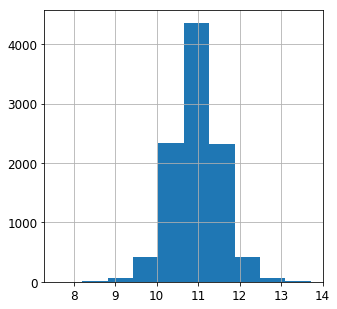

In [22]:
np.log(df.annual_inc+1).hist()
#use log dollar for modeling; +1 to avoid log(0)

In [23]:
df[df.annual_inc.isna()]
#there is one person has NaN for annual income and employer, along with lots of other fields being NaN
#yet is_bad = 0...this data point would favor low debt_to_income (=1)

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
7593,0,NaN,1,NONE,NaN,not verified,n,"I am moving to Florida and would like to borrow $6,700 to cover for expenses and security deposit.",other,Moving expenses and security deposit,100xx,NY,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,f,NaN,2,PC1


In [24]:
df.verification_status.value_counts(dropna=False)
#what's the difference between the two verified values? I think should combine those two

not verified                4367
VERIFIED - income           3214
VERIFIED - income source    2419
Name: verification_status, dtype: int64

In [25]:
df.pymnt_plan.value_counts(dropna=False)
#

n    9998
y       2
Name: pymnt_plan, dtype: int64

In [26]:
df[df.pymnt_plan=='y']
#is_bad two for two... but probably too few data points to make it in the model

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1222,1,emory adventist,1,RENT,84000.0,VERIFIED - income,y,Borrower added on 09/16/10 > this loan is to help consolidate some business loans. My nursing ...,debt consolidation,inventory,300xx,GA,19.54,0.0,01/01/1992,0.0,NaN,NaN,11.0,0.0,42809,88.1,32.0,f,0.0,2,PC1
4719,1,Terumo Cardiovascular,2,MORTGAGE,158000.0,VERIFIED - income,y,Borrower added on 10/18/11 > Unfortunately I was laid off from my job sometime ago and was out...,debt consolidation small business,debt consolidation,980xx,WA,16.81,1.0,01/01/1994,0.0,11.0,NaN,10.0,0.0,38283,70.3,27.0,f,0.0,1,PC4


In [27]:
df.Notes[:10]

Id
1                                                                                                     NaN
2       Borrower added on 04/14/11 > I will be using this loan to pay off expenses accrued in the last...
3                                                                                                     NaN
4                                                                                                     NaN
5                                       I want to consolidate my debt, pay for a vacation and buy a ring.
6                                                                                                     NaN
7       Borrower added on 05/18/10 > mick credit card consolidation loan - 100% payoff of credit card ...
8       Borrower added on 11/29/11 > Loan is for debt consolidation and will be paid timely.  Employed...
9                                                                                                     NaN
10    This loan would be for a 2006 PT Crui

In [28]:
df.purpose[:10]

Id
1                                    Medical
2                 My Debt Consolidation Loan
3                           AP Personal Loan
4                    Debt Consolidation Loan
5                                consolidate
6                                  16-Oct-10
7                      mick credit card loan
8                                    CC loan
9                              Consolidation
10    FICO score 762 want's to buy a new car
Name: purpose, dtype: object

In [29]:
df.purpose_cat[:10]

Id
1                medical
2     debt consolidation
3            credit card
4     debt consolidation
5     debt consolidation
6                  other
7            credit card
8     debt consolidation
9     debt consolidation
10                   car
Name: purpose_cat, dtype: object

In [30]:
df.purpose_cat.value_counts()
# note > purpose > purpose_cat, the information gets more concise from notes to purpose_cat
# There might be some useful signal from extracting Notes and Purpose but I doubt it...
# but this is not NLP focused task... so dropping notes and purpose and onehot purpose_cat

debt consolidation                   4454
credit card                          1273
other                                1026
home improvement                      800
major purchase                        546
small business                        461
car                                   349
wedding                               250
medical                               183
moving                                159
educational                           107
debt consolidation small business     102
house                                  94
vacation                               94
renewable energy                       19
other small business                   18
credit card small business             17
small business small business          12
home improvement small business        11
educational small business              5
major purchase small business           5
car small business                      3
house small business                    3
moving small business             

In [31]:
df.zip_code.head()
#there some interesting socio-economic data available online (such as County Health Ranking and Area Deprivation Index) that map to zip.
#but that's probably beyond the scope of this task, dropping zip code

Id
1    766xx
2    660xx
3    916xx
4    124xx
5    439xx
Name: zip_code, dtype: object

In [32]:
df.addr_state.value_counts(dropna=False)

CA    1748
NY     958
FL     714
TX     700
NJ     482
VA     392
IL     386
PA     378
GA     357
MA     331
OH     292
MD     282
WA     217
AZ     210
CT     195
NC     194
MI     176
CO     175
MO     167
MN     136
SC     126
WI     124
AL     119
NV     114
OR     109
KY     103
OK      98
LA      97
UT      68
KS      57
DC      54
RI      53
NH      50
AR      48
WV      45
NM      43
DE      35
HI      32
AK      26
MT      25
WY      23
SD      19
VT      18
MS       9
TN       5
NE       3
IN       3
IA       2
ME       1
ID       1
Name: addr_state, dtype: int64

In [33]:
df[df.is_bad==1]['addr_state'].value_counts(dropna=False)

CA    261
FL    112
NY    108
TX     74
NJ     67
GA     53
VA     49
MA     46
IL     41
PA     35
NC     33
MD     33
OH     30
WA     28
AZ     28
NV     27
CT     27
MO     26
CO     22
AL     21
MI     20
SC     17
OK     13
WI     12
OR     12
UT     10
KY     10
NM     10
NH      8
LA      8
MN      8
AK      7
WV      5
HI      5
AR      5
RI      5
KS      4
DC      3
DE      3
MT      3
VT      2
NE      1
TN      1
SD      1
MS      1
Name: addr_state, dtype: int64

In [34]:
df.addr_state.value_counts(dropna=False)/df[df.is_bad==1]['addr_state'].value_counts(dropna=False)
#I'm afraid the variance in this ratio isn't enough to justify the use of state in model...dropping it.
#should avoid geo-discriminating algorithms?

AK     3.714286
AL     5.666667
AR     9.600000
AZ     7.500000
CA     6.697318
CO     7.954545
CT     7.222222
DC    18.000000
DE    11.666667
FL     6.375000
GA     6.735849
HI     6.400000
IA          NaN
ID          NaN
IL     9.414634
IN          NaN
KS    14.250000
KY    10.300000
LA    12.125000
MA     7.195652
MD     8.545455
ME          NaN
MI     8.800000
MN    17.000000
MO     6.423077
MS     9.000000
MT     8.333333
NC     5.878788
NE     3.000000
NH     6.250000
NJ     7.194030
NM     4.300000
NV     4.222222
NY     8.870370
OH     9.733333
OK     7.538462
OR     9.083333
PA    10.800000
RI    10.600000
SC     7.411765
SD    19.000000
TN     5.000000
TX     9.459459
UT     6.800000
VA     8.000000
VT     9.000000
WA     7.750000
WI    10.333333
WV     9.000000
WY          NaN
Name: addr_state, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa41c622d68>,
      dtype=object)

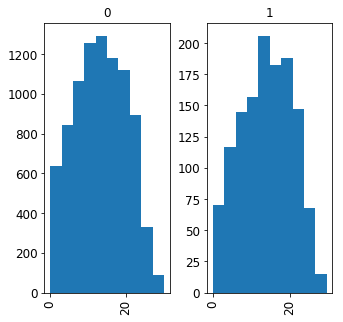

In [35]:
df.debt_to_income.hist(by=[df.is_bad])

In [36]:
df.groupby(['is_bad'])['debt_to_income'].mean()

is_bad
0    13.260886
1    13.861799
Name: debt_to_income, dtype: float64

In [37]:
df.delinq_2yrs.value_counts(dropna=False)
#bin and treat as category,0,1,2 and above
#the more the worse obviously

0.0     8910
1.0      822
2.0      186
3.0       50
4.0       14
5.0        6
NaN        5
6.0        3
7.0        2
11.0       1
8.0        1
Name: delinq_2yrs, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa41c4f0588>,
      dtype=object)

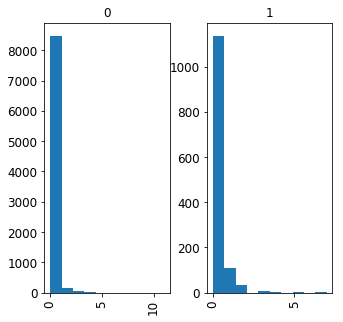

In [38]:
df.delinq_2yrs.hist(by=[df.is_bad])

In [39]:
df.groupby(['is_bad'])['delinq_2yrs'].mean()

is_bad
0    0.143908
1    0.176834
Name: delinq_2yrs, dtype: float64

In [40]:
df.earliest_cr_line[:20]
#create a feature being length of credit history, only year needed

Id
1     12/01/1992
2     11/01/2005
3     06/01/1970
4     09/01/1982
5     10/01/1999
6     12/01/1999
7     11/01/1979
8     04/01/2006
9     02/01/2001
10    05/01/1995
11    12/01/1990
12    06/01/1993
13    04/01/1996
14    10/01/1996
15    10/01/1999
16    01/01/1993
17    09/01/1993
18    01/01/2003
19    11/01/1999
20    12/01/1996
Name: earliest_cr_line, dtype: object

In [41]:
#df['earliest_cr_line_date'] = pd.to_datetime(df.earliest_cr_line,format='%m/%d/%Y',errors='coerce')

In [42]:
#df.earliest_cr_line_date[:10]

In [43]:
int('12/01/1996'[-4:])

1996

In [44]:
df['earliest_cr_year'] = df.earliest_cr_line.apply(lambda x: float(x[-4:]) if pd.notnull(x) else np.nan)

In [45]:
df['earliest_cr_year'].max()
df['earliest_cr_year'].min()

2008.0

1950.0

In [46]:
df.earliest_cr_year.value_counts(dropna=False)

2000.0    839
1998.0    748
1999.0    715
2001.0    642
1997.0    601
1996.0    592
1995.0    518
1994.0    513
2002.0    503
2003.0    455
2004.0    439
2005.0    401
1993.0    383
2006.0    323
1991.0    257
1990.0    255
1992.0    254
1989.0    208
2007.0    180
1987.0    176
1988.0    159
1986.0    116
1984.0    112
1985.0     92
1983.0     74
1982.0     65
1979.0     43
1978.0     40
1980.0     39
1981.0     38
2008.0     34
1976.0     31
1977.0     28
1973.0     18
1975.0     17
1970.0     14
1974.0     14
1972.0     13
1971.0     11
1969.0      9
1968.0      7
1967.0      6
NaN         5
1963.0      2
1965.0      2
1964.0      2
1966.0      2
1962.0      2
1956.0      1
1950.0      1
1959.0      1
Name: earliest_cr_year, dtype: int64

In [47]:
df['cr_line_history_yr'] = df['earliest_cr_year'].max() - df['earliest_cr_year']

In [48]:
df[df.cr_line_history_yr.isnull()].shape
#few nan, can consider imputation...but imputation is generally a bad idea

(5, 29)

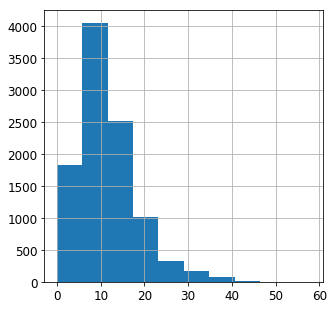

In [49]:
df.cr_line_history_yr.hist()

In [50]:
df.groupby(['is_bad'])['cr_line_history_yr'].mean()

is_bad
0    11.383908
1    11.009266
Name: cr_line_history_yr, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa41c3daef0>,
      dtype=object)

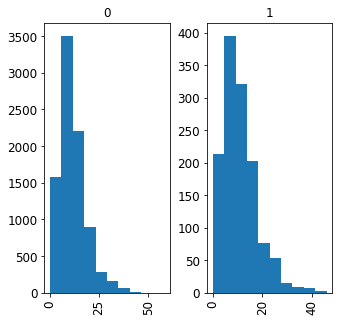

In [51]:
df.cr_line_history_yr.hist(by=[df.is_bad])
#binning is the way to go it seems

0.0     4602
1.0     2684
2.0     1431
3.0      731
4.0      227
5.0      152
6.0       76
7.0       42
8.0       27
9.0       10
NaN        5
10.0       2
11.0       2
18.0       2
16.0       1
24.0       1
14.0       1
12.0       1
25.0       1
17.0       1
15.0       1
Name: inq_last_6mths, dtype: int64

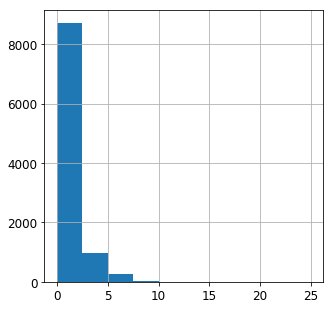

In [52]:
df.inq_last_6mths.hist()
df.inq_last_6mths.value_counts(dropna=False)
#bin it

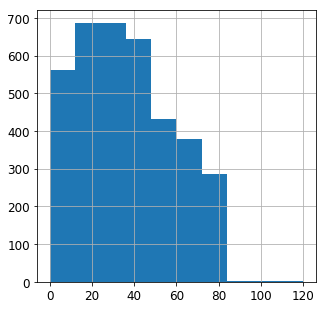

In [53]:
df.mths_since_last_delinq.hist()
#bin: nan, 0-36, 

In [54]:
df.mths_since_last_delinq.value_counts(dropna=False)

NaN      6316
0.0       163
30.0       69
34.0       66
38.0       65
23.0       65
44.0       64
24.0       64
33.0       63
20.0       63
18.0       61
29.0       60
17.0       60
25.0       59
19.0       59
46.0       59
14.0       58
15.0       58
13.0       57
37.0       56
39.0       55
41.0       54
26.0       54
22.0       53
16.0       53
12.0       52
40.0       52
35.0       52
28.0       52
31.0       51
27.0       50
43.0       49
36.0       49
8.0        48
47.0       48
32.0       47
21.0       47
42.0       47
48.0       46
45.0       46
6.0        45
7.0        45
58.0       43
55.0       42
53.0       42
10.0       42
11.0       42
49.0       41
3.0        40
71.0       40
62.0       39
61.0       39
60.0       37
4.0        37
59.0       36
76.0       36
50.0       36
73.0       35
9.0        34
56.0       34
70.0       33
69.0       32
68.0       32
72.0       31
5.0        31
54.0       30
66.0       29
2.0        29
52.0       29
79.0       28
75.0       28
67.0  

In [55]:
df.groupby(['is_bad'])['mths_since_last_delinq'].mean()
df.groupby(['is_bad'])['mths_since_last_delinq'].median()

is_bad
0    35.878225
1    35.966403
Name: mths_since_last_delinq, dtype: float64

is_bad
0    34.0
1    34.0
Name: mths_since_last_delinq, dtype: float64

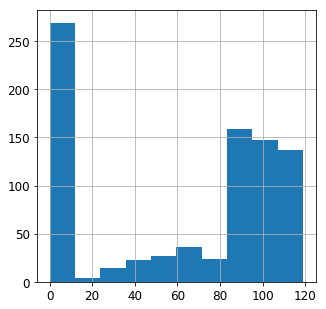

In [56]:
df.mths_since_last_record.hist()

In [57]:
df.mths_since_last_record.value_counts(dropna=False)

NaN      9160
0.0       267
89.0       21
116.0      18
86.0       17
87.0       17
92.0       17
100.0      16
114.0      16
104.0      16
105.0      15
106.0      15
88.0       15
96.0       14
95.0       14
111.0      13
94.0       13
101.0      13
85.0       13
113.0      13
109.0      13
98.0       12
91.0       12
99.0       12
93.0       11
108.0      11
118.0      11
110.0      10
115.0      10
117.0      10
107.0      10
90.0        9
112.0       9
97.0        9
102.0       8
103.0       7
63.0        7
67.0        6
45.0        5
55.0        5
61.0        5
38.0        4
73.0        4
77.0        4
76.0        4
56.0        4
119.0       3
65.0        3
62.0        3
54.0        3
43.0        3
72.0        3
80.0        3
26.0        3
66.0        3
58.0        3
82.0        2
50.0        2
60.0        2
40.0        2
44.0        2
20.0        2
27.0        2
30.0        2
51.0        2
49.0        2
71.0        2
53.0        2
70.0        2
46.0        2
25.0        2
39.0  

In [58]:
df.groupby(['is_bad'])['mths_since_last_record'].mean()
df.groupby(['is_bad'])['mths_since_last_record'].median()
#bin: nan, 0,20-80,80 and above

is_bad
0    59.057183
1    76.780488
Name: mths_since_last_record, dtype: float64

is_bad
0    85.0
1    92.0
Name: mths_since_last_record, dtype: float64

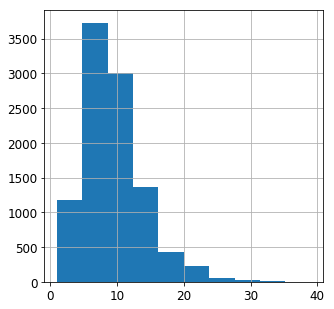

In [59]:
df.open_acc.hist()#bin or impute

0.0    9422
1.0     550
2.0      18
NaN       5
3.0       5
Name: pub_rec, dtype: int64

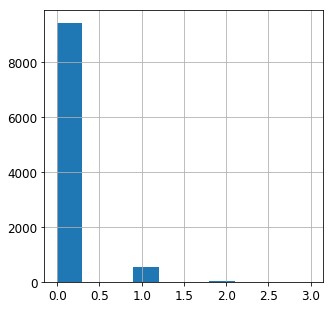

In [60]:
df.pub_rec.hist()
df.pub_rec.value_counts(dropna=False)#categorize

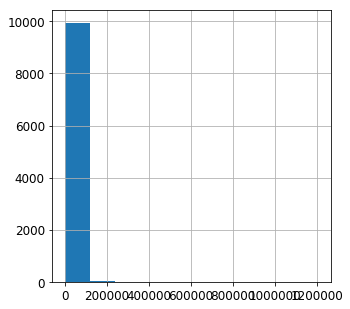

In [61]:
df.revol_bal.hist()#very skewed, log($+1) 

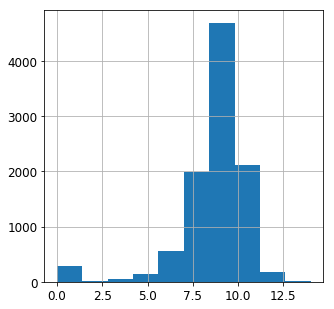

In [62]:
np.log(df.revol_bal+1).hist()

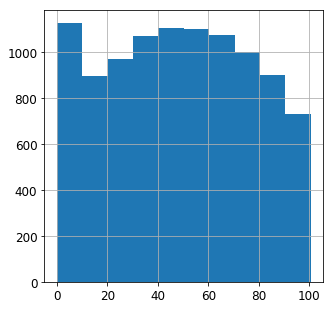

In [63]:
df.revol_util.hist()

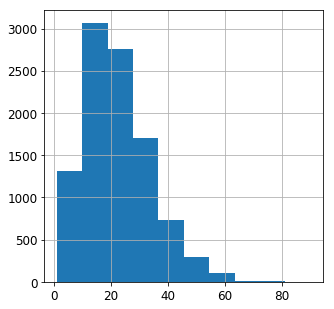

In [64]:
df.total_acc.hist()

In [65]:
df.initial_list_status.value_counts(dropna=False)

f    9983
m      17
Name: initial_list_status, dtype: int64

In [66]:
df.collections_12_mths_ex_med.describe()

count    9968.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: collections_12_mths_ex_med, dtype: float64

In [67]:
df.collections_12_mths_ex_med.value_counts(dropna=False)
#this one is weird

0.0    9968
NaN      32
Name: collections_12_mths_ex_med, dtype: int64

In [68]:
df.groupby(['is_bad'])['collections_12_mths_ex_med'].apply(lambda x: x.isna().sum())
#this one is not as useful as it sounds

is_bad
0    31
1     1
Name: collections_12_mths_ex_med, dtype: int64

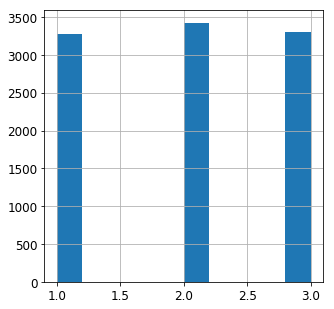

In [69]:
df.mths_since_last_major_derog.hist()

In [70]:
df.mths_since_last_major_derog.value_counts()

2    3424
3    3299
1    3277
Name: mths_since_last_major_derog, dtype: int64

In [71]:
df.policy_code.value_counts()
#can use but cannot explain without code mapping/description.

PC3    2098
PC5    2025
PC1    1978
PC2    1962
PC4    1937
Name: policy_code, dtype: int64

In [72]:
df.groupby(['policy_code'])['is_bad'].sum()
#probably not much signal from policy 

policy_code
PC1    253
PC2    285
PC3    239
PC4    254
PC5    264
Name: is_bad, dtype: int64

# data processing

In [73]:
#adding prefix "input_cat/input_num/output" for model ready engineered features: 
#categorial and numerical (continuous) input, and output (target)

In [74]:
# we'll have to repeat to pd.cut and pd.get_dummies a couple times, 
# as it's hard to automate since each variable would need different cut

In [75]:
df = pd.read_csv(os.path.join(LOCAL_PATH,FILENAME))

In [76]:
df.set_index('Id',inplace=True)

In [77]:
df.shape

(10000, 27)

In [78]:
df.head()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,zip_code,addr_state,debt_to_income,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,NaN,medical,Medical,766xx,TX,10.87,0.0,12/01/1992,0.0,NaN,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
2,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using this loan to pay off expenses accrued in the last...,debt consolidation,My Debt Consolidation Loan,660xx,KS,9.15,0.0,11/01/2005,2.0,NaN,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
3,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,NaN,credit card,AP Personal Loan,916xx,CA,11.24,0.0,06/01/1970,0.0,NaN,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
4,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,Debt Consolidation Loan,124xx,NY,6.18,1.0,09/01/1982,0.0,16.0,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
5,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacation and buy a ring.",debt consolidation,consolidate,439xx,OH,19.03,0.0,10/01/1999,4.0,NaN,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


In [79]:
df['output_is_bad'] = df.is_bad 

In [80]:
df['input_cat_employerNA'] = df.emp_title.apply(lambda x: 1 if pd.isnull(x) else 0)

In [81]:
df.input_cat_employerNA.value_counts()

0    9408
1     592
Name: input_cat_employerNA, dtype: int64

In [82]:
df["emp_length"] = df.emp_length.apply(lambda x: float(x) if x!='na' else 0)

In [83]:
df.emp_length.value_counts()

10.0    2160
1.0     2083
2.0     1183
3.0     1010
4.0      889
5.0      779
6.0      535
7.0      421
8.0      351
9.0      331
0.0      250
22.0       5
11.0       2
33.0       1
Name: emp_length, dtype: int64

In [84]:
df["input_cat_emp_length"] = pd.cut(df["emp_length"],
                               bins=[-1,0.,1.,3.,6.,9.,np.inf],
                               labels=['NA','1yr','3yr','6yr','9yr','10plusyr']
                                   )

In [85]:
df.input_cat_emp_length.value_counts(dropna=False)

6yr         2203
3yr         2193
10plusyr    2168
1yr         2083
9yr         1103
NA           250
Name: input_cat_emp_length, dtype: int64

In [86]:
df.shape

(10000, 30)

In [87]:
df = pd.concat([df,pd.get_dummies(df['input_cat_emp_length'], prefix='input_cat_emp_length')],axis=1)
df.drop(['input_cat_emp_length'],axis=1, inplace=True)

In [88]:
df.shape

(10000, 35)

In [89]:
df.input_cat_emp_length_1yr.value_counts()

0    7917
1    2083
Name: input_cat_emp_length_1yr, dtype: int64

In [90]:
df = pd.concat([df,pd.get_dummies(df['home_ownership'], prefix='input_cat_home_ownership')],axis=1)
df.drop(['home_ownership'],axis=1, inplace=True)

In [91]:
# need to be careful about the highly correlated variables generated from onehot of categorical variable (for example, male, female)
# here we are not using drop_first=True as we would like to see the effect of each category level.

In [92]:
df.input_cat_home_ownership_RENT.value_counts()

0    5255
1    4745
Name: input_cat_home_ownership_RENT, dtype: int64

In [93]:
df.annual_inc.median()

58000.0

In [94]:
df.annual_inc.fillna(df.annual_inc.median(),inplace=True)
#impute this NA as median income

In [95]:
df.annual_inc.describe()

count     10000.000000
mean      68201.991238
std       48587.930068
min        2000.000000
25%       40000.000000
50%       58000.000000
75%       82000.000000
max      900000.000000
Name: annual_inc, dtype: float64

In [96]:
df['input_num_log_annual_inc'] = np.log(df.annual_inc+1)

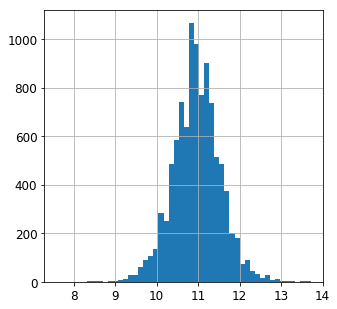

In [97]:
df.input_num_log_annual_inc.hist(bins=50)

In [98]:
df['input_cat_verified'] = df.verification_status.apply(lambda x: 0 if x=='not verified' else 1)

In [99]:
df.input_cat_verified.value_counts()

1    5633
0    4367
Name: input_cat_verified, dtype: int64

In [100]:
df['input_cat_pymnt_plan'] = df.pymnt_plan.apply(lambda x: 1 if x=='y' else 0)

In [101]:
df.input_cat_pymnt_plan.value_counts()

0    9998
1       2
Name: input_cat_pymnt_plan, dtype: int64

In [102]:
df.shape

(10000, 42)

In [103]:
df = pd.concat([df,pd.get_dummies(df['purpose_cat'], prefix='input_cat_purpose_cat')],axis=1)
df.drop(['purpose_cat'],axis=1, inplace=True)

In [104]:
df.columns = df.columns.str.replace(' ', '_')

In [105]:
df.input_cat_purpose_cat_major_purchase_small_business.value_counts()

0    9995
1       5
Name: input_cat_purpose_cat_major_purchase_small_business, dtype: int64

In [106]:
df['input_num_debt_to_income'] = df.debt_to_income
#good as is

In [107]:
df["input_cat_delinq_2yrs"] = pd.cut(df["delinq_2yrs"],
                               bins=[-1,0.,1.,2.,np.inf],
                               labels=['0','1','2','gt2']
                                   )

In [108]:
df.input_cat_delinq_2yrs.value_counts(dropna=False)

0      8910
1       822
2       186
gt2      77
NaN       5
Name: input_cat_delinq_2yrs, dtype: int64

In [109]:
df = pd.concat([df,pd.get_dummies(df['input_cat_delinq_2yrs'], prefix='input_cat_delinq_2yrs',dummy_na=True)],axis=1)
df.drop(['input_cat_delinq_2yrs'],axis=1, inplace=True)

In [110]:
df['earliest_cr_year'] = df.earliest_cr_line.apply(lambda x: float(x[-4:]) if pd.notnull(x) else np.nan)

In [111]:
df['cr_line_history_yr'] = df['earliest_cr_year'].max() - df['earliest_cr_year']
#don't know when is application year so assuming the max, it's relative so signal won't be affected

In [112]:
df["input_cat_cr_line_history_yr"] = pd.cut(df["cr_line_history_yr"],
                               bins=[-1,5.,10.,15.,20.,np.inf],
                               labels=['5yr','10yr','15yr','20yr','gt20yr']
                                   )

In [113]:
df.input_cat_cr_line_history_yr.value_counts(dropna=False)

10yr      3447
15yr      2607
5yr       1832
20yr      1133
gt20yr     976
NaN          5
Name: input_cat_cr_line_history_yr, dtype: int64

In [114]:
df = pd.concat([df,pd.get_dummies(df['input_cat_cr_line_history_yr'], prefix='input_cat_cr_line_history_yr',dummy_na=True)],axis=1)
df.drop(['input_cat_cr_line_history_yr'],axis=1, inplace=True)

In [115]:
df.shape

(10000, 82)

In [116]:
df["input_cat_inq_last_6mths"] = pd.cut(df["inq_last_6mths"],
                               bins=[-1,0.,1.,2.,np.inf],
                               labels=['0','1','2','gt2']
                                   )

In [117]:
df.input_cat_inq_last_6mths.value_counts(dropna=False)

0      4602
1      2684
2      1431
gt2    1278
NaN       5
Name: input_cat_inq_last_6mths, dtype: int64

In [118]:
df = pd.concat([df,pd.get_dummies(df['input_cat_inq_last_6mths'], prefix='input_cat_inq_last_6mths',dummy_na=True)],axis=1)
df.drop(['input_cat_inq_last_6mths'],axis=1, inplace=True)

In [119]:
df["input_cat_mths_since_last_delinq"] = pd.cut(df["mths_since_last_delinq"],
                               bins=[-1,24.,48.,np.inf],
                               labels=['2yr','4yr','gt4yr']
                                   )

In [120]:
df.input_cat_mths_since_last_delinq.value_counts(dropna=False)

NaN      6316
4yr      1313
2yr      1312
gt4yr    1059
Name: input_cat_mths_since_last_delinq, dtype: int64

In [121]:
df = pd.concat([df,pd.get_dummies(df['input_cat_mths_since_last_delinq'], prefix='input_cat_mths_since_last_delinq',dummy_na=True)],axis=1)
df.drop(['input_cat_mths_since_last_delinq'],axis=1, inplace=True)

In [122]:
df["input_cat_mths_since_last_record"] = pd.cut(df["mths_since_last_record"],
                               bins=[-1,0.,84.,np.inf],
                               labels=['0','7yr','gt7yr']
                                   )
#7-yr ARM? 

In [123]:
df.input_cat_mths_since_last_record.value_counts(dropna=False)

NaN      9160
gt7yr     443
0         267
7yr       130
Name: input_cat_mths_since_last_record, dtype: int64

In [124]:
df = pd.concat([df,pd.get_dummies(df['input_cat_mths_since_last_record'], prefix='input_cat_mths_since_last_record',dummy_na=True)],axis=1)
df.drop(['input_cat_mths_since_last_record'],axis=1, inplace=True)

In [125]:
df['input_num_open_acc'] = df.open_acc.fillna(df.open_acc.median())
#impute with median (only 5 NaN)

In [126]:
df["input_cat_pub_rec"] = pd.cut(df["pub_rec"],
                               bins=[-1,0.,1.,np.inf],
                               labels=['0','1','gt1']
                                   )

In [127]:
df.input_cat_pub_rec.value_counts(dropna=False)

0      9422
1       550
gt1      23
NaN       5
Name: input_cat_pub_rec, dtype: int64

In [128]:
df = pd.concat([df,pd.get_dummies(df['input_cat_pub_rec'], prefix='input_cat_pub_rec',dummy_na=True)],axis=1)
df.drop(['input_cat_pub_rec'],axis=1, inplace=True)

In [129]:
df['input_num_log_revol_bal'] = np.log(df.revol_bal+1)

In [130]:
df['input_num_revol_util'] = df.revol_util.fillna(df.revol_util.median())

In [131]:
df['input_num_total_acc'] = df.total_acc.fillna(df.total_acc.median())

In [132]:
df['input_cat_initial_list_status_m'] = df.initial_list_status.apply(lambda x: 1 if x=='m' else 0)

In [133]:
df['input_cat_collections_12_mths_ex_med_NA'] = df.collections_12_mths_ex_med.apply(lambda x: 0 if x==0 else 1)
#it's either 0 or NA, get_dummies for both levels would be wrong

In [134]:
df['input_cat_mths_since_last_major_derog'] = df.mths_since_last_major_derog.astype(str)

df = pd.concat([df,pd.get_dummies(df['input_cat_mths_since_last_major_derog'], prefix='input_cat_mths_since_last_major_derog',dummy_na=False)],axis=1)
df.drop(['input_cat_mths_since_last_major_derog'],axis=1, inplace=True)

In [135]:
df = pd.concat([df,pd.get_dummies(df['policy_code'], prefix='input_cat_policy_code',dummy_na=False)],axis=1)

In [136]:
df.input_cat_policy_code_PC4.value_counts()

0    8063
1    1937
Name: input_cat_policy_code_PC4, dtype: int64

In [137]:
df.filter(regex='input|output').shape
df.filter(regex='input|output').columns
df.filter(regex='input|output').dtypes

(10000, 86)

Index(['output_is_bad', 'input_cat_employerNA', 'input_cat_emp_length_NA', 'input_cat_emp_length_1yr', 'input_cat_emp_length_3yr', 'input_cat_emp_length_6yr', 'input_cat_emp_length_9yr', 'input_cat_emp_length_10plusyr', 'input_cat_home_ownership_MORTGAGE', 'input_cat_home_ownership_NONE', 'input_cat_home_ownership_OTHER', 'input_cat_home_ownership_OWN', 'input_cat_home_ownership_RENT', 'input_num_log_annual_inc', 'input_cat_verified', 'input_cat_pymnt_plan', 'input_cat_purpose_cat_car', 'input_cat_purpose_cat_car_small_business', 'input_cat_purpose_cat_credit_card', 'input_cat_purpose_cat_credit_card_small_business', 'input_cat_purpose_cat_debt_consolidation', 'input_cat_purpose_cat_debt_consolidation_small_business', 'input_cat_purpose_cat_educational', 'input_cat_purpose_cat_educational_small_business', 'input_cat_purpose_cat_home_improvement', 'input_cat_purpose_cat_home_improvement_small_business', 'input_cat_purpose_cat_house', 'input_cat_purpose_cat_house_small_business',
       

output_is_bad                                                int64
input_cat_employerNA                                         int64
input_cat_emp_length_NA                                      uint8
input_cat_emp_length_1yr                                     uint8
input_cat_emp_length_3yr                                     uint8
input_cat_emp_length_6yr                                     uint8
input_cat_emp_length_9yr                                     uint8
input_cat_emp_length_10plusyr                                uint8
input_cat_home_ownership_MORTGAGE                            uint8
input_cat_home_ownership_NONE                                uint8
input_cat_home_ownership_OTHER                               uint8
input_cat_home_ownership_OWN                                 uint8
input_cat_home_ownership_RENT                                uint8
input_num_log_annual_inc                                   float64
input_cat_verified                                           i

In [138]:
#save modeling data frame
#could round the float64 to reduce the size of csv...but not really necessary for small data
df.filter(regex='input|output').to_csv(os.path.join(LOCAL_PATH,'df.csv'))

# pilot models

In [139]:
df = pd.read_csv(os.path.join(LOCAL_PATH,'df.csv'))

In [140]:
#df = pd.read_csv(os.path.join(LOCAL_PATH,FILENAME))

In [141]:
df.set_index('Id',inplace=True)

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 86 columns):
output_is_bad                                              10000 non-null int64
input_cat_employerNA                                       10000 non-null int64
input_cat_emp_length_NA                                    10000 non-null int64
input_cat_emp_length_1yr                                   10000 non-null int64
input_cat_emp_length_3yr                                   10000 non-null int64
input_cat_emp_length_6yr                                   10000 non-null int64
input_cat_emp_length_9yr                                   10000 non-null int64
input_cat_emp_length_10plusyr                              10000 non-null int64
input_cat_home_ownership_MORTGAGE                          10000 non-null int64
input_cat_home_ownership_NONE                              10000 non-null int64
input_cat_home_ownership_OTHER                             10000 non-null int64
input_cat_h

In [143]:
df.head()

,output_is_bad,input_cat_employerNA,input_cat_emp_length_NA,input_cat_emp_length_1yr,input_cat_emp_length_3yr,input_cat_emp_length_6yr,input_cat_emp_length_9yr,input_cat_emp_length_10plusyr,input_cat_home_ownership_MORTGAGE,input_cat_home_ownership_NONE,input_cat_home_ownership_OTHER,input_cat_home_ownership_OWN,input_cat_home_ownership_RENT,input_num_log_annual_inc,input_cat_verified,input_cat_pymnt_plan,input_cat_purpose_cat_car,input_cat_purpose_cat_car_small_business,input_cat_purpose_cat_credit_card,input_cat_purpose_cat_credit_card_small_business,input_cat_purpose_cat_debt_consolidation,input_cat_purpose_cat_debt_consolidation_small_business,input_cat_purpose_cat_educational,input_cat_purpose_cat_educational_small_business,input_cat_purpose_cat_home_improvement,input_cat_purpose_cat_home_improvement_small_business,input_cat_purpose_cat_house,input_cat_purpose_cat_house_small_business,input_cat_purpose_cat_major_purchase,input_cat_purpose_cat_major_purchase_small_business,input_cat_purpose_cat_medical,input_cat_purpose_cat_medical_small_business,input_cat_purpose_cat_moving,input_cat_purpose_cat_moving_small_business,input_cat_purpose_cat_other,input_cat_purpose_cat_other_small_business,input_cat_purpose_cat_renewable_energy,input_cat_purpose_cat_small_business,input_cat_purpose_cat_small_business_small_business,input_cat_purpose_cat_vacation,input_cat_purpose_cat_vacation_small_business,input_cat_purpose_cat_wedding,input_cat_purpose_cat_wedding_small_business,input_num_debt_to_income,input_cat_delinq_2yrs_0,input_cat_delinq_2yrs_1,input_cat_delinq_2yrs_2,input_cat_delinq_2yrs_gt2,input_cat_delinq_2yrs_nan,input_cat_cr_line_history_yr_5yr,input_cat_cr_line_history_yr_10yr,input_cat_cr_line_history_yr_15yr,input_cat_cr_line_history_yr_20yr,input_cat_cr_line_history_yr_gt20yr,input_cat_cr_line_history_yr_nan,input_cat_inq_last_6mths_0,input_cat_inq_last_6mths_1,input_cat_inq_last_6mths_2,input_cat_inq_last_6mths_gt2,input_cat_inq_last_6mths_nan,input_cat_mths_since_last_delinq_2yr,input_cat_mths_since_last_delinq_4yr,input_cat_mths_since_last_delinq_gt4yr,input_cat_mths_since_last_delinq_nan,input_cat_mths_since_last_record_0,input_cat_mths_since_last_record_7yr,input_cat_mths_since_last_record_gt7yr,input_cat_mths_since_last_record_nan,input_num_open_acc,input_cat_pub_rec_0,input_cat_pub_rec_1,input_cat_pub_rec_gt1,input_cat_pub_rec_nan,input_num_log_revol_bal,input_num_revol_util,input_num_total_acc,input_cat_initial_list_status_m,input_cat_collections_12_mths_ex_med_NA,input_cat_mths_since_last_major_derog_1,input_cat_mths_since_last_major_derog_2,input_cat_mths_since_last_major_derog_3,input_cat_policy_code_PC1,input_cat_policy_code_PC2,input_cat_policy_code_PC3,input_cat_policy_code_PC4,input_cat_policy_code_PC5
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,1,1,0,0,0,0,10.819798,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10.87,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,15.0,1,0,0,0,9.399969,12.1,44.0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,1,10.576866,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.15,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,4.0,1,0,0,0,9.221775,64.0,5.0,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,11.082158,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.24,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,4.0,1,0,0,0,4.406719,0.6,8.0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,1,1,0,0,0,0,10.959558,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.18,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,6.0,1,0,0,0,9.213436,37.1,23.0,0,0,0,1,0,0,1,0,0,0
5,0,0,0,0,0,0,0,1,1,0,0,0,0,10.819878,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19.03,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,8.0,1,0,0,0,9.281823,40.4,21.0,0,0,0,0,1,0,0,1,0,0


In [144]:
df.output_is_bad.mean()

0.1295

In [145]:
from sklearn.model_selection import train_test_split

In [146]:
from sklearn import metrics

In [147]:
y = df.output_is_bad.values

X = df.filter(regex='input').values

In [148]:
X.max()
X.min()
y.max()
y.min()

100.6

0.0

1

0

In [149]:
X.shape
y.shape

(10000, 85)

(10000,)

## MLP

In [150]:
#probably not much benefit to use neural network for such small dataset

In [151]:
#Here scaling is used (for practical reason) for faster approaching to global minima at error surface

In [152]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [153]:
X_scale = scaler.fit_transform(X)

In [154]:
X_scale.shape
X_scale.max()

(10000, 85)

1.0

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state = 42)

In [156]:
print(len(y_train),'train samples')
print(len(y_test),'test samples')

8000 train samples
2000 test samples


In [157]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

#rmsprop seems to overfit when many inputs to my previous experience (and sgd is normally better)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid',name='preds'))

model.summary()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test,y_test),
                    epochs=20,
                    batch_size=1000)
score = model.evaluate(X_test, y_test, batch_size=1000)


model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                5504      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
preds (Dense)                (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
___________________

In [158]:
from sklearn import metrics

In [159]:
y_score = model.predict(X_test)

y_score = y_score.reshape(y_test.shape[0],)

y_score.mean()
y_test.mean()


0.150643

0.1365

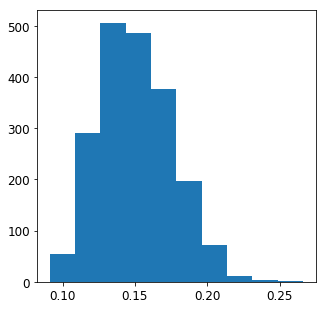

In [160]:
plt.hist(y_score);#weird distribution

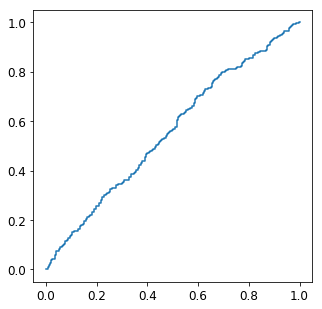

In [161]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
plt.plot(fpr,tpr);

In [162]:
metrics.auc(fpr,tpr)

0.5546279622712743

In [163]:
auc=metrics.roc_auc_score(y_test, y_score)

print('AUC: {0:0.2f}'.format(auc))

AUC: 0.55


In [164]:
y_score = model.predict(X_train)
y_score = y_score.reshape(y_train.shape[0],)
y_score.mean()
y_train.mean()

0.15012829

0.12775

0.5721678251861175

AUC: 0.57


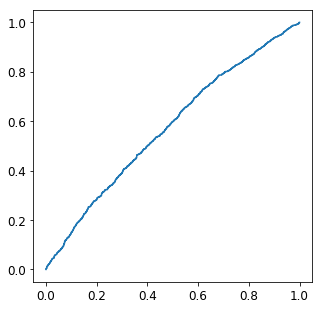

In [165]:
fpr, tpr, _ = metrics.roc_curve(y_train, y_score)

plt.plot(fpr,tpr);

metrics.auc(fpr,tpr)

auc=metrics.roc_auc_score(y_train, y_score)

print('AUC: {0:0.2f}'.format(auc))

## LR

In [166]:
from sklearn.linear_model import LogisticRegressionCV#so no need to manually regularize LR with CV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [167]:
y = df.output_is_bad.values
X = df.filter(regex='input').values
X_scale = scaler.fit_transform(X)

In [168]:
#for LR scaling helps a bit

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=0)
logreg = LogisticRegressionCV(cv=5,solver='liblinear')
#tried a few solver but little difference in result
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [170]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


In [171]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2622    3]
 [ 321   54]]


In [172]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2625
           1       0.95      0.14      0.25       375

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.92      0.57      0.60      3000
weighted avg       0.90      0.89      0.86      3000



In [173]:
from sklearn.metrics import roc_auc_score,roc_curve,log_loss,average_precision_score,precision_recall_curve

In [174]:
plt.rcParams["figure.figsize"] = [5,5]

log loss:  3.8782115207417274


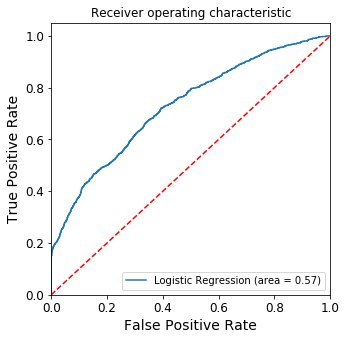

In [175]:
logloss = log_loss(y_train, logreg.predict(X_train))
print('log loss: ',logloss)
logit_roc_auc = roc_auc_score(y_train, logreg.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show();

log loss:  3.7301886502477846


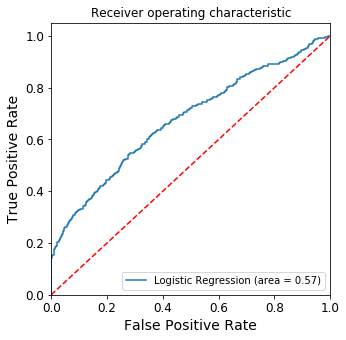

In [176]:
logloss = log_loss(y_test, logreg.predict(X_test))
print('log loss: ',logloss)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show();

In [177]:
y_pred = logreg.predict_proba(X_test)[:,1]

(array([1509., 1133.,  237.,   50.,   14.,    4.,    0.,    0.,    0.,
          53.]),
 array([6.13845500e-05, 1.00054693e-01, 2.00048001e-01, 3.00041309e-01,
        4.00034617e-01, 5.00027926e-01, 6.00021234e-01, 7.00014542e-01,
        8.00007850e-01, 9.00001158e-01, 9.99994467e-01]),
 <a list of 10 Patch objects>)

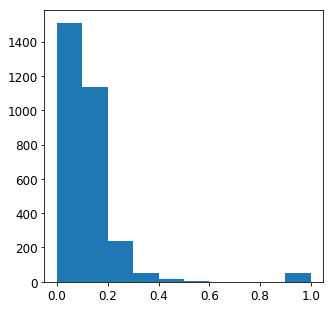

In [178]:
plt.hist(y_pred)

In [179]:
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.5f}'.format(average_precision))

Average precision-recall score: 0.36494


In [180]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auprc = metrics.auc(recall,precision)
auprc

0.36446065878457445

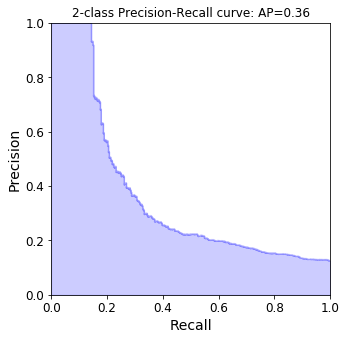

In [181]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post');
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b');

plt.xlabel('Recall');
plt.ylabel('Precision');
plt.ylim([0.0, 1.0]);
plt.xlim([0.0, 1.0]);
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));


In [182]:
# the shape is weird

## K-fold CV (using SVM as example)

In [183]:
df = pd.read_csv(os.path.join(LOCAL_PATH,'df.csv'))
df.set_index('Id',inplace=True)

In [184]:
from scipy import interp
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [185]:
y = df.output_is_bad.values
X = df.filter(regex='input').values
X_scale = scaler.fit_transform(X)

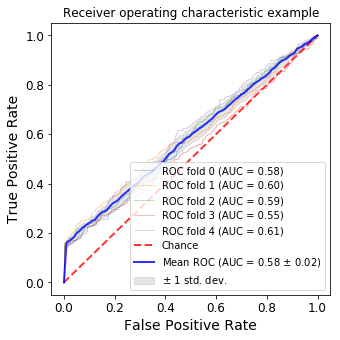

In [186]:
n_samples, n_features = X_scale.shape

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear',gamma='auto',probability=True)
#use linear kernel, or it's very slow

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X_scale, y):
    probas_ = classifier.fit(X_scale[train], y[train]).predict_proba(X_scale[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

In [187]:
from sklearn.metrics import roc_auc_score,log_loss

log loss:  3.7071619997204137


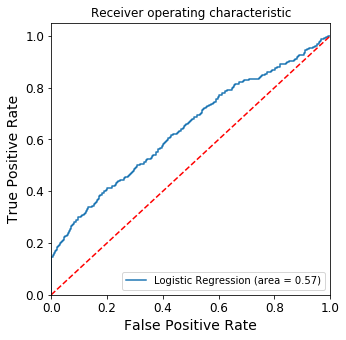

In [188]:
logloss = log_loss(y_test, classifier.predict(X_test))
print('log loss: ',logloss)
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show();

In [189]:
#difference in AUC indicates overfitting

## GB (with feature importance)

In [190]:
#XGBoost model automatically calculates feature importance. 

In [191]:
#There is no free lunch, but I find these are usually good starting places for quick classifier trials (besides LR): 
#XGBClassifier (from xgboost, faster than the one from sklearn), RandomForestClassifier (from sklearn), MLP (keras with tensorflow backend)

In [192]:
# plot feature importance using built-in function
#from numpy import loadtxt
from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot

In [193]:
#no need for scaling here

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

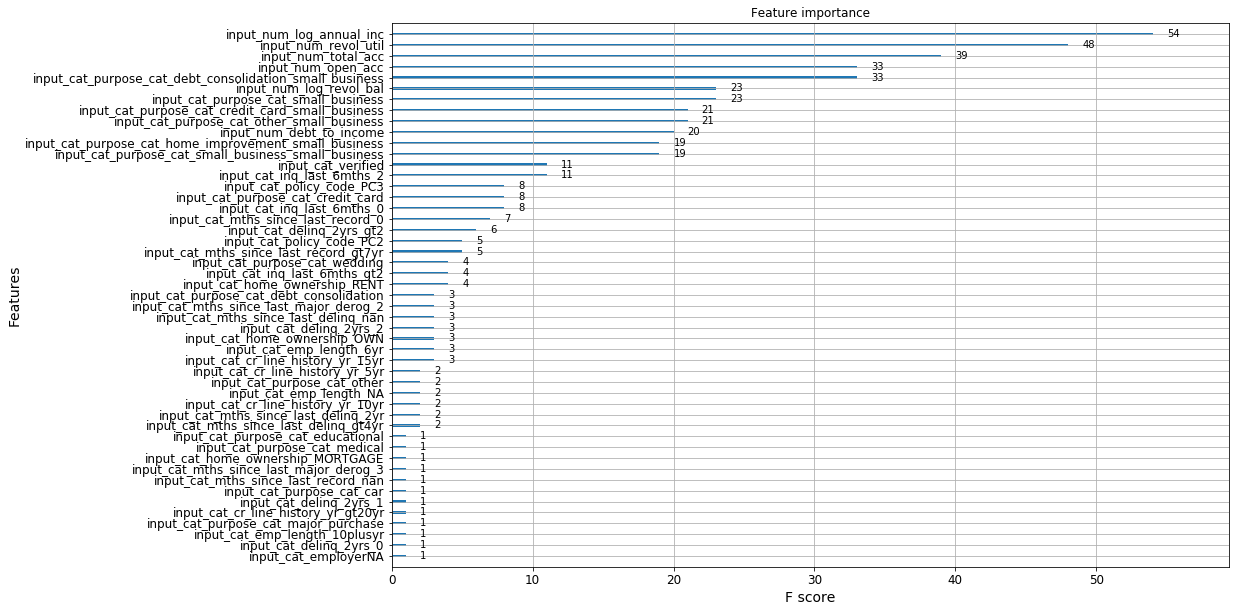

In [195]:
plt.rcParams["figure.figsize"] = [15,10]
# fit model with training data
model = XGBClassifier()#using the scikit-learn API in xgboost
model.fit(X_train, y_train)
model.get_booster().feature_names = df.filter(regex='input').columns.tolist()
# plot feature importance
plot_importance(model.get_booster())
pyplot.show();

In [196]:
#so the top 3 features are 
#1) Annual income of the loan applicant - log scale
#2) Loan applicant’s percentage utilization of their revolving credit facility 
#3) Total number of accounts for the loan applicant
#Makes sense, can consult with domain expert / literature to confirm.

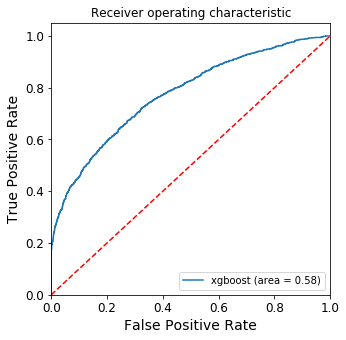

In [197]:
plt.rcParams["figure.figsize"] = [5,5]
xgb = model.fit(X_train, y_train)
roc_auc = roc_auc_score(y_train, xgb.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, xgb.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgboost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show();

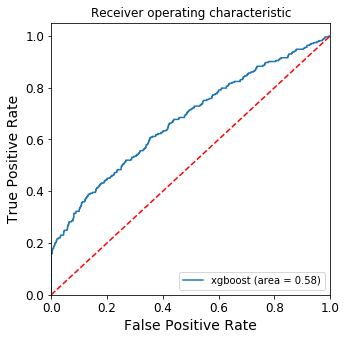

In [198]:
roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='xgboost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show();

In [199]:
from sklearn.metrics import classification_report

print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1727
           1       1.00      0.15      0.27       273

   micro avg       0.88      0.88      0.88      2000
   macro avg       0.94      0.58      0.60      2000
weighted avg       0.90      0.88      0.85      2000



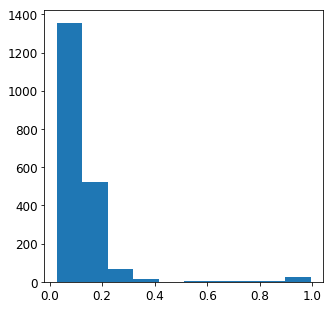

In [200]:
plt.hist(xgb.predict_proba(X_test)[:,1]);

In [201]:
log_loss(y_test, xgb.predict(X_test))

3.989228673612184

In [202]:
#performance is similar to LR.